# Approximate Factor Models, Vector Autoregression and Temporal Convolutional Networks from FRED-MD

Extract an approximate factor structure that reduces the number of dimensions (variables) in a large set of economic time series (FRED-MD), with number of components automatically selected by an information criterion and outliers replaced with an EM approach. 

Contrast Vector Autoregression and Temporal Convolutional Networks to model the time-series persistance of the extracted factors, and compare prediction errors.

- PCA, EM, vector autoregression, temporal convolutional networks
- Bai and Ng (2002), McCracken and Ng (2016), and others

Terence Lim

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import os
import re
import time
from datetime import datetime
from finds.alfred import Alfred, fred_md, fred_qd
from finds.solve import integration_order, is_inlier

from settings import settings
imgdir = os.path.join(settings['images'], 'ts')
alf = Alfred(api_key=settings['fred']['api_key'])

## Load FRED-MD and FRED-QD
- test stationarity after applying transform codes

In [2]:
# Transformation Codes, and Stationarity
qdf, qt = fred_qd(202004) # 202004      # from vintage April 2020
mdf, mt = fred_md(201505) # 201505

print('Number of time series and suggested transformations, by tcode:')
tcodes = pd.concat([Series(alf.tcode_[i], name=i).to_frame().T
                    for i in range(1,8)], axis=0).fillna(False)
tcodes = tcodes.join(qt['transform'].value_counts().rename('fred-qd'))\
               .join(mt['transform'].value_counts().rename('fred-md'))\
               .fillna(0).astype({'fred-qd': int, 'fred-md': int})

# Estimate and Compare Integration Order
out = {}
for label, df, t in [['md', mdf, mt], ['qd', qdf, qt]]:
    stationary = dict()
    for series_id, tcode in t['transform'].items():
        if tcode in [1, 2, 3, 4, 5, 6]:
            s = df[series_id] if tcode <= 3 else np.log(df[series_id])
            order = integration_order(s.dropna(), pvalue=0.05)
            stationary[series_id] = {
                'tcode': tcode,
                'I(p)': order,
                'different': '*' if (tcode - 1) % 3 != order else '',
                'title': alf.header(series_id)}
            #print(series_id, order, tcode)
    stationary = DataFrame.from_dict(stationary, orient='index')
    stationary = stationary.sort_values(stationary.columns.to_list())
    c = stationary.groupby(['tcode','I(p)'])['title'].count().reset_index()
    out[label] = c.pivot(index='tcode', columns='I(p)',
                         values='title').fillna(0).astype(int)
    out[label].columns=[f"I({p})" for p in out[label].columns]
print('Series by tcode, transformations and estimated order of integration:')
c = pd.concat([tcodes.drop(columns='fred-md'), out['qd'], tcodes['fred-md'],
    	       out['md']], axis=1).fillna(0).astype(int)
c

Number of time series and suggested transformations, by tcode:
Series by tcode, transformations and estimated order of integration:


,diff,log,pct_change,fred-qd,I(0),I(1),I(2),fred-md,I(0),I(1),I(2)
1,0,0,0,22,15,7,0,17,17,0,0
2,1,0,0,32,7,24,1,19,5,14,0
3,2,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,10,6,4,0
5,1,1,0,143,33,105,5,53,8,45,0
6,2,1,0,50,0,23,27,34,0,23,11
7,1,0,1,1,0,0,0,1,0,0,0


## PCA-EM Algorithm for Approximate Factors Model

- Extract approximate factor, with outliers and removed replaced through an EM approach. 
- Show auto-selected number of factors, and more correlated series to each factor, for FRED-MD and FRED-QD
- Bai and Ng (2002)

In [3]:
from finds.alfred import pcaEM, BaiNg, marginalR2

for freq, df, t in [['monthly', mdf, mt], ['quarterly', qdf, qt]]:
    df = qdf.copy()
    t = qt['transform']

    # Apply tcode transformations
    transformed = []
    for col in df.columns:
        transformed.append(alf.transform(df[col], tcode=t[col], freq=freq[0]))
    data = pd.concat(transformed, axis=1).iloc[2:]
    cols = list(data.columns)
    sample = data.index[((np.count_nonzero(np.isnan(data), axis=1)==0) |
                         (data.index <= 20141231)) & (data.index >= 19600301)]

    # set missing and outliers in X to NaN
    X = np.array(data.loc[sample])
    X[~is_inlier(X, method='iq10')] = np.nan

    # compute PCA EM and auto select number of components, r
    x, model = pcaEM(X, kmax=None, p=2, tol=1e-21, echo=False)
    r = BaiNg(x, p=2, standardize=True)

    # show marginal R2's of series to each component
    mR2 = marginalR2(x, standardize=True)
    print(f"FRED-{freq[0].upper()}D {freq} series:")
    print(f"Explained by {r} factors: {np.sum(np.mean(mR2[:r,:], axis=1)):.3f}"
          f" ({len(x)} obs: {min(sample)}-{max(sample)})")
    for k in range(r):
        print()
        print(f"Factor:{1+k:2d}  Variance Explained={np.mean(mR2[k, :]):6.3f}")
        args = np.argsort(-mR2[k, :])
        for i, arg in enumerate(args[:10]):
            print(f"{mR2[k, arg]:6.3f} {cols[arg]:16s} {alf.header(cols[arg])}")


FRED-MD monthly series:
Explained by 7 factors: 0.498 (240 obs: 19600331-20191231)

Factor: 1  Variance Explained= 0.201
 0.838 USPRIV           All Employees, Total Private
 0.818 USGOOD           All Employees, Goods-Producing
 0.817 OUTMS            Manufacturing Sector: Real Output
 0.812 PAYEMS           All Employees, Total Nonfarm
 0.812 IPMANSICS        Industrial Production: Manufacturing (SIC)
 0.806 INDPRO           Industrial Production: Total Index
 0.776 MANEMP           All Employees, Manufacturing
 0.772 HOANBS           Nonfarm Business Sector: Hours of All Persons
 0.767 DMANEMP          All Employees, Durable Goods
 0.764 UNRATE           Unemployment Rate

Factor: 2  Variance Explained= 0.082
 0.500 AAAFFM           Moody's Seasoned Aaa Corporate Bond Minus Federal Funds Rate
 0.476 T5YFFM           5-Year Treasury Constant Maturity Minus Federal Funds Rate
 0.461 PERMIT           New Privately-Owned Housing Units Authorized in Permit-Issuing Places: Total Units
 0.

 0.229 NWPI             *** NWPI ***
 0.226 USSERV           All Employees, Other Services
 0.214 COMPRMS          Manufacturing Sector: Real Compensation Per Hour

Factor: 5  Variance Explained= 0.038
 0.358 OPHMFG           Manufacturing Sector: Real Output Per Hour of All Persons
 0.304 HWI              Help Wanted Index for United States
 0.291 NWPI             *** NWPI ***
 0.289 AWHMAN           Average Weekly Hours of Production and Nonsupervisory Employees, Manufacturing
 0.262 OPHPBS           Business Sector: Real Output Per Hour of All Persons
 0.233 UNRATELT         *** UNRATELT ***
 0.228 OPHNFB           Nonfarm Business Sector: Real Output Per Hour of All Persons
 0.218 UNLPNBS          Nonfarm Business Sector: Unit Nonlabor Payments
 0.215 ULCMFG           Manufacturing Sector: Unit Labor Cost
 0.193 TLBSNNCBBDI      *** TLBSNNCBBDI ***

Factor: 6  Variance Explained= 0.030
 0.264 CONSPI           Nonrevolving consumer credit to Personal Income
 0.242 ULCBS            B

## Extract factors

In [4]:
# pipe.fit through 20141231, pipe.transform through 20201231
df, t = fred_md(202104) # 201505
sample_date = 20141231
data = []
for col in df.columns:
    data.append(alf.transform(df[col], tcode=t['transform'][col], freq='m'))
data = pd.concat(data, axis=1).iloc[2:]
cols = list(data.columns)
sample = data.index[((np.count_nonzero(np.isnan(data), axis=1)==0) |
                     (data.index <= sample_date)) & (data.index >= 19600301)]
train_sample = sample[sample <= sample_date]
test_sample = sample[sample <= 20191231]

# replace missing and outliers with PCA EM and fixed number of components r=8
r = 8
X = np.array(data.loc[train_sample])
X[~is_inlier(X, method='iq10')] = np.nan
x, model = pcaEM(X, kmax=r, p=0, echo=False)

# Extract factors with SVD
y = ((x-x.mean(axis=0).reshape(1,-1))/x.std(axis=0,ddof=0).reshape(1,-1))
u, s, vT = np.linalg.svd(y, full_matrices=False)
factors = DataFrame(u[:, :r], columns=np.arange(1, 1+r),
                    index=pd.DatetimeIndex(train_sample.astype(str), freq='M'))
Series(s[:r]**2 / np.sum(s**2), index=np.arange(1, r+1), name='R2').to_frame().T


,1,2,3,4,5,6,7,8
R2,0.149606,0.071396,0.06826,0.057014,0.043102,0.033687,0.031621,0.027009


## Equivalently with sklearn PCA

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(r))])
pipe.fit(x)                        # fit model on training data
X = np.array(data.loc[sample])     # to transform on full sample data
x, model = pcaEM(X, kmax=8, p=0, echo=False)  # replace missing (not outlier)
factors = DataFrame(StandardScaler().fit_transform(pipe.transform(x)),
                    index=pd.DatetimeIndex(sample.astype(str), freq='infer'),
                    columns=np.arange(1, 1+r))
Series(pipe.named_steps['pca'].explained_variance_ratio_,
       index=np.arange(1,r+1), name='R2').to_frame().T   # sanity check

,1,2,3,4,5,6,7,8
R2,0.149606,0.071396,0.06826,0.057014,0.043102,0.033687,0.031621,0.027009


## Retrieve recession periods from FRED

In [6]:
usrec = alf('USREC', freq='m')  
usrec.index = pd.DatetimeIndex(usrec.index.astype(str), freq='infer')
g = usrec.astype(bool) | usrec.shift(-1, fill_value=0).astype(bool)
g = (g != g.shift(fill_value=0)).cumsum()[g].to_frame()
g = g.reset_index().groupby('USREC')['date'].agg(['first','last'])
vspans = [(v[0], v[1]) for k, v in g.iterrows()]
print(alf.header('USREC'))
DataFrame(vspans, columns=['Start', 'End'])

NBER based Recession Indicators for the United States from the Period following the Peak through the Trough


,Start,End
0,1854-12-31,1854-12-31
1,1857-06-30,1858-12-31
2,1860-10-31,1861-06-30
3,1865-04-30,1867-12-31
4,1869-06-30,1870-12-31
5,1873-10-31,1879-03-31
6,1882-03-31,1885-05-31
7,1887-03-31,1888-04-30
8,1890-07-31,1891-05-31
9,1893-01-31,1894-06-30


## Plot extracted factors alongside recession periods

Look visually how extracts performed in recessionary or other time periods

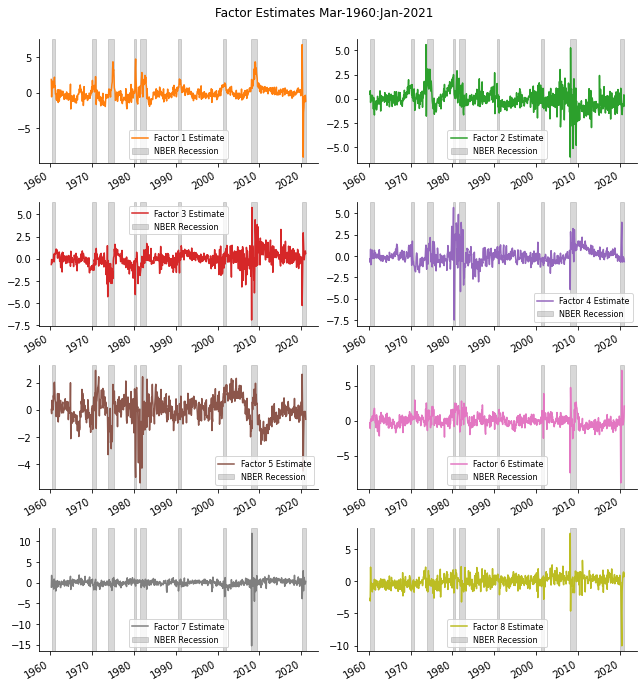

In [8]:
fig = plt.figure(figsize=(9, 10), num=1, clear=True)
for col in factors.columns:
    ax = fig.add_subplot(4, 2, col)
    flip = -np.sign(max(factors[col]) + min(factors[col])) # try match sign
    (flip*factors[col]).plot(ax=ax, color=f"C{col}")
    for a,b in vspans:
        if b >= min(factors.index):
            ax.axvspan(max(a, min(factors.index)), min(b, max(factors.index)),
                       alpha=0.3, color='grey')
    ax.legend([f"Factor {col} Estimate", 'NBER Recession'], fontsize=8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"Factor Estimates {factors.index[0]:%b-%Y}:"
             f"{factors.index[-1]:%b-%Y}", fontsize=12)
plt.savefig(os.path.join(imgdir, 'approximate.jpg'))
plt.show()

# Vector Autoregression Model of the Extracted Factors

predicting composites of, rather than individual, macroeconomic time series

In [10]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from finds.display import plot_bands

maxlags = 16
train_date = '2014-12-31'
train_index = factors.index[factors.index <= train_date]
test1_index = factors.index[(factors.index >= train_index[-maxlags]) &
                            (factors.index <= '2019-12-31')]
test2_index = factors.index[(factors.index >= test1_index[-maxlags])]
train_data = factors.loc[train_index].copy()
test1_data = factors.loc[test1_index].copy()
test2_data = factors.loc[test2_index].copy()
M = train_data.shape[1]
model = VAR(train_data, freq='M')

## Selecting lag order

With different information criteria

In [11]:
results = {p: model.fit(p) for p in range(1, maxlags+1)}   # VAR(p) models
DataFrame({ic: model.fit(maxlags=maxlags, ic=ic).k_ar
           for ic in ['aic', 'fpe', 'hqic', 'bic']},
          index=['lag order selected by:'])\
          .rename_axis(columns='Information Criterion:')

Information Criterion:,aic,fpe,hqic,bic
lag order selected by:,9,9,3,2


## Extract and plot impulse response function with confidence bands

The lagged coefficients estimated from the Vector Autoregression produce a multi-period cumulative forecast

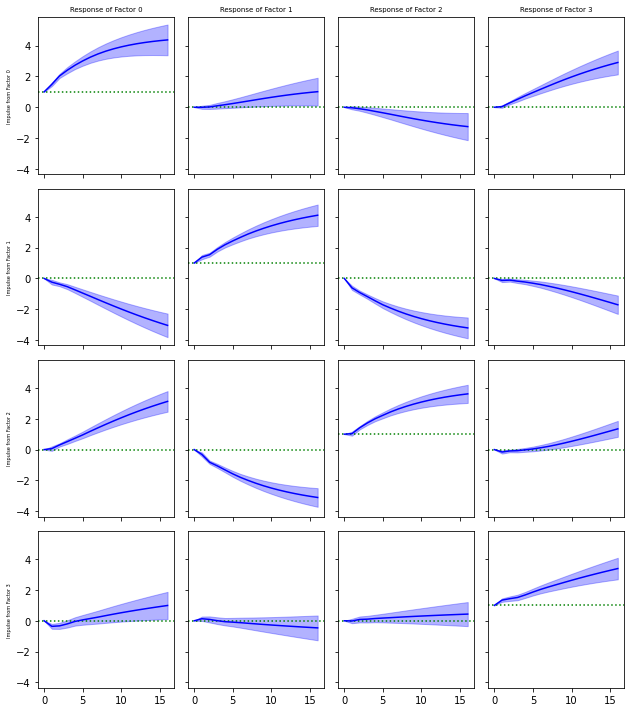

In [12]:
irf = results[2].irf(maxlags)
m = 4  #M
fig, axes = plt.subplots(m, m, figsize=(9,10), num=1, clear=True,
                         sharex=True, sharey=True)
for impulse in range(m):
    for response in range(m):
        plot_bands(mean=irf.cum_effects[:, impulse, response],
                   stderr=irf.cum_effect_stderr()[:, impulse, response],
                   hline=1 if impulse == response else 0,
                   title=None if impulse else f"Response of Factor {response}",
                   ylabel=None if response else f"Impulse from Factor {impulse}",
                   fontsize=3, ax=axes[impulse, response])
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'impulse.jpg'))
plt.show()

## Collect one-period ahead forecasts and errors in train and test sets


In [13]:
from sklearn.metrics import mean_squared_error as mse
mean_error = dict()
var_error= {p: dict() for p in results}
for x in [train_data, test1_data, test2_data]:
    for i in range(maxlags, len(x)):
        # error of unconditional mean forecast
        mean_error[x.index[i]] = mse(x.iloc[i].values, train_data.mean().values)
        
        # error VAR(p) model forecasts
        for p in var_error:
            pred = results[p].forecast(x.iloc[(i-p):i].values, 1)
            var_error[p][x.index[i]] = mse([x.iloc[i].values], pred)

## Compute mean test and train set errors of all models

Unsurprisingly, lower training errors with greater lag orders, but test error minimized around p=2

In [14]:
errors = {0: Series(mean_error, name="TrainSampleMean")}  # VAR(0)
errors.update({p: Series(var_error[p], name=f"VAR({p})") for p in var_error})

out = [Series({'Train Error': e.loc[e.index <= train_date].mean(),
               'Test1 Error': e.loc[test1_index].mean(),
               'Test2 Error': e.loc[test2_index].mean()},
              name=e.name) for p, e in errors.items()]
out = pd.concat(out, axis=1).T.rename_axis(columns="1961-07-31...2019-12-31:")
out


1961-07-31...2019-12-31:,Train Error,Test1 Error,Test2 Error
TrainSampleMean,0.970961,0.441382,2.678603
VAR(1),0.654662,0.330449,2.854284
VAR(2),0.609067,0.309076,2.904283
VAR(3),0.585080,0.303534,3.035429
VAR(4),0.567825,0.301428,3.133837
VAR(5),0.551661,0.302137,3.286103
VAR(6),0.537279,0.302843,3.333357
VAR(7),0.520826,0.307894,3.349115
VAR(8),0.507618,0.302649,3.337701
VAR(9),0.492257,0.307919,3.311939


## Plot Train and Test Error of  VAR(p) Models

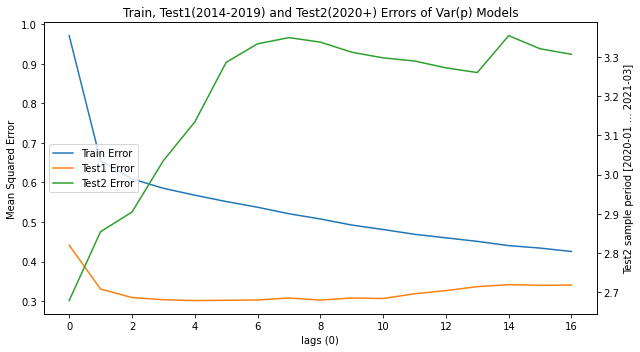

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), num=1, clear=True)
ax.plot(np.arange(len(out)), out['Train Error'], color=f"C0")
ax.plot(np.arange(len(out)), out['Test1 Error'], color=f"C1")
ax.plot([], [], color=f"C2")
bx = ax.twinx()
bx.plot(np.arange(len(out)), out['Test2 Error'], color=f"C2")
ax.set_title(f'Train, Test1(2014-2019) and Test2(2020+) Errors of Var(p) Models')
ax.set_ylabel('Mean Squared Error')
bx.set_ylabel('Test2 sample period [2020-01 ... 2021-03]')
ax.set_xlabel('lags (0)')
ax.legend(['Train Error', 'Test1 Error', 'Test2 Error'], loc='center left')
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'varerr.jpg'))
plt.show()


## Plot monthly mean squared error

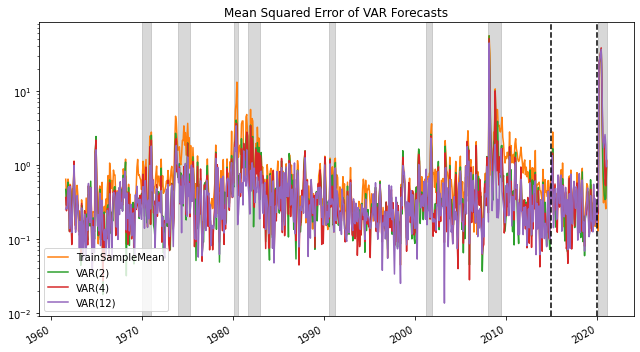

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), num=1, clear=True)
ax.set_yscale('log')
for i, p in enumerate([0, 2, 4, 12]):
    errors[p].plot(ax=ax, c=f'C{i+1}', style='-')
for a,b in vspans:
    if b >= min(errors[0].index):
        ax.axvspan(max(a, min(errors[0].index)), min(b, max(errors[0].index)),
                   alpha=0.3, color='grey')
ax.set_title('Mean Squared Error of VAR Forecasts')
ax.axvline(max(train_index), color='black', linestyle='--')
ax.axvline(max(test1_index), color='black', linestyle='--')
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'varmse.jpg'))
plt.show()

# Temporal 1D Convolutional Net (TCN)

Instead of VAR, model the factor time series with TCN

In [17]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TCN(torch.nn.Module):
    class CausalConv1dBlock(torch.nn.Module):
        """Building block Conv1d, ReLU, skip, dropout, dilation and padding"""
        def __init__(self, in_channels, out_channels, kernel_size, dilation,
                     dropout):
            super().__init__()
            self.network = torch.nn.Sequential(
                torch.nn.ConstantPad1d(((kernel_size-1)*dilation, 0), 0),
                torch.nn.Conv1d(in_channels, out_channels, kernel_size,
                                dilation=dilation),
                torch.nn.ReLU(),
                torch.nn.ConstantPad1d(((kernel_size-1)*dilation, 0), 0),
                torch.nn.Conv1d(out_channels, out_channels, kernel_size,
                                dilation=dilation),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout))
            self.skip = lambda x: x
            if in_channels != out_channels:     # downsample if necessary
                self.skip = torch.nn.Conv1d(in_channels, out_channels,1)

        def forward(self, x):
            return self.network(x) + self.skip(x)  # with skip connection


    def __init__(self, n_features, layers=[8, 8, 8], kernel_size=3, dropout=0.0):
        """TCN model by connecting multiple convolution layers"""
        super().__init__()
        c = n_features
        L = []
        for total_dilation, l in enumerate(layers):
            L.append(self.CausalConv1dBlock(in_channels=c,
                                            out_channels=l,
                                            kernel_size=kernel_size,
                                            dilation=2*(total_dilation+1),
                                            dropout=dropout))
            c = l
        self.network = torch.nn.Sequential(*L)
        self.classifier = torch.nn.Conv1d(c, n_features, 1)

    def forward(self, x):
        """input is (B, n_features, L)), linear expects (B, * n_features)"""
        return self.classifier(self.network(x))

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self


## Create input data from training set

In [18]:
seq_len = 16    # length of each input sequence for TCN
train_exs = [train_data.iloc[i-(seq_len+1):i].values
             for i in range(seq_len+1, len(train_data))]
n_features = train_data.shape[1]


## Fit TCN models with increasing layers of convolution and dropout

Experiment with choices for two hyperparameters: number of block layers, and dropout rate

In [21]:
layers = [1, 2, 3, 4]                      # range of convolution block layers
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]  # range of dropout rates
batch_size = 8
step_size = 300      # learning rate scheduler step size
lr = 0.01            # initial learning rate
num_lr = 6
res = []             # to collect results summaries
tcn_error = dict()   # to store prediction errors
for layer in layers:
    for dropout in dropouts:
        # Set model, optimizer, loss function and learning rate scheduler
        model = TCN(n_features, layers=[16]*layer, kernel_size=2,
                    dropout=dropout).to(device)
        print(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1,
                                                    step_size=step_size)
        loss_function = nn.MSELoss()

        # Run training loop over num_epochs with batch_size
        num_epochs = step_size * num_lr
        for epoch in range(num_epochs):
            idxs = np.arange(len(train_exs))   # shuffle indxs into batches
            random.shuffle(idxs)
            batches = [idxs[i:(i+batch_size)]
                       for i in range(0, len(idxs), batch_size)]
    
            total_loss = 0.0               # train by batch
            model.train()
            for batch in batches:
                # input has shape (batch_size=8, n_features=8, seq_len=16)
                train_ex = torch.tensor([[train_exs[idx][seq] for idx in batch]
                                         for seq in range(seq_len+1)])\
                                .permute(1,2,0).float().to(device)
                model.zero_grad()
                X = train_ex[:,:,:-1]
                Y = train_ex[:,:,1:]
                output = model(X)
                loss = loss_function(output, Y)  # calculated over all outputs
                total_loss += float(loss)
                loss.backward()
                optimizer.step()
            scheduler.step()
            if (epoch % (step_size//2)) == 0:
                print(epoch, layer, dropout, optimizer.param_groups[0]['lr'],
                      total_loss/len(batches))
            model.eval()

        # Compute MSE of one-period ahead forecast error in train and test sets
        e = dict()
        for x in [train_data, test1_data, test2_data]:
            for i in range(seq_len, len(x)):
                X = torch.tensor(x.iloc[(i-seq_len):i].values.T)\
                         .unsqueeze(0).float().to(device)
                pred = model(X)
                e[x.index[i]] = mse([x.iloc[i].values],
                                    pred[:,:,-1].cpu().detach().numpy())
        name=f"TCN{layer}_{dropout*100:.0f}"
        model.save(os.path.join(imgdir, name + '.pt'))
        e = Series(e, name=name)
        tcn_error[name] = e
        res.append(Series({'depth': layer, 'dropout': dropout,
                           'Train Error': float(e[e.index <= train_date].mean()),
                           'Test1 Error': float(e[test1_index].mean()),
                           'Test2 Error': float(e[test2_index].mean())},
                          name=name))
        #print(pd.concat(res, axis=1).T)
res = pd.concat(res, axis=1).T
model

TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(2, 0), value=0)
        (1): Conv1d(8, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(2, 0), value=0)
        (4): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (5): ReLU()
        (6): Dropout(p=0.0, inplace=False)
      )
      (skip): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
    )
  )
  (classifier): Conv1d(16, 8, kernel_size=(1,), stride=(1,))
)
0 1 0.0 0.01 0.6698968473040028
150 1 0.0 0.01 0.31508046609384044
300 1 0.0 0.001 0.2909606233423139
450 1 0.0 0.001 0.2840809972933781
600 1 0.0 0.0001 0.28220977588200274
750 1 0.0 0.0001 0.2849424347097491
900 1 0.0 1e-05 0.2829083270496792
1050 1 0.0 1e-05 0.28224879779197554
1200 1 0.0 1.0000000000000002e-06 0.2820308817389571
1350 1 0.0 1.0000000000000002e-06 0.28277472452616986
1500 1 0.0 1.0000000000000002e-07 0.28274981199223

0 2 0.1 0.01 0.6957877660975044
150 2 0.1 0.01 0.3122181901593267
300 2 0.1 0.001 0.2779342050169721
450 2 0.1 0.001 0.26107983585493066
600 2 0.1 0.0001 0.2583638753420041
750 2 0.1 0.0001 0.25272650703971766
900 2 0.1 1e-05 0.26034236745333966
1050 2 0.1 1e-05 0.2548884966491181
1200 2 0.1 1.0000000000000002e-06 0.25870233755788685
1350 2 0.1 1.0000000000000002e-06 0.26882394853933356
1500 2 0.1 1.0000000000000002e-07 0.2646726522548699
1650 2 0.1 1.0000000000000002e-07 0.25334908730453914
TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(2, 0), value=0)
        (1): Conv1d(8, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(2, 0), value=0)
        (4): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (5): ReLU()
        (6): Dropout(p=0.2, inplace=False)
      )
      (skip): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
    )
    (1): 

TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(2, 0), value=0)
        (1): Conv1d(8, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(2, 0), value=0)
        (4): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (5): ReLU()
        (6): Dropout(p=0.1, inplace=False)
      )
      (skip): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
    )
    (1): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(4, 0), value=0)
        (1): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(4,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(4, 0), value=0)
        (4): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(4,))
        (5): ReLU()
        (6): Dropout(p=0.1, inplace=False)
      )
    )
    (2): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(6, 0), 

0 3 0.5 0.01 0.6811764313850874
150 3 0.5 0.01 0.4492520918080836
300 3 0.5 0.001 0.4310091660346514
450 3 0.5 0.001 0.4019911462142144
600 3 0.5 0.0001 0.40168810332262955
750 3 0.5 0.0001 0.3972912313025675
900 3 0.5 1e-05 0.40642426632068773
1050 3 0.5 1e-05 0.39455960470217244
1200 3 0.5 1.0000000000000002e-06 0.3964441827049962
1350 3 0.5 1.0000000000000002e-06 0.410735943067221
1500 3 0.5 1.0000000000000002e-07 0.38972007271684245
1650 3 0.5 1.0000000000000002e-07 0.4010654824015535
TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(2, 0), value=0)
        (1): Conv1d(8, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(2, 0), value=0)
        (4): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (5): ReLU()
        (6): Dropout(p=0.0, inplace=False)
      )
      (skip): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
    )
    (1): Cau

0 4 0.3 0.01 0.696835579695525
150 4 0.3 0.01 0.34004071005332615
300 4 0.3 0.001 0.33356471083782335
450 4 0.3 0.001 0.29650605791880763
600 4 0.3 0.0001 0.2998715898504964
750 4 0.3 0.0001 0.283100563250942
900 4 0.3 1e-05 0.29557821136197926
1050 4 0.3 1e-05 0.281429417523337
1200 4 0.3 1.0000000000000002e-06 0.27816756731934017
1350 4 0.3 1.0000000000000002e-06 0.28610672443001356
1500 4 0.3 1.0000000000000002e-07 0.2864916118574731
1650 4 0.3 1.0000000000000002e-07 0.285232158354771
TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(2, 0), value=0)
        (1): Conv1d(8, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(2, 0), value=0)
        (4): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (5): ReLU()
        (6): Dropout(p=0.4, inplace=False)
      )
      (skip): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
    )
    (1): Caus

TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(2, 0), value=0)
        (1): Conv1d(8, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(2, 0), value=0)
        (4): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (5): ReLU()
        (6): Dropout(p=0.5, inplace=False)
      )
      (skip): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
    )
    (1): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(4, 0), value=0)
        (1): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(4,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(4, 0), value=0)
        (4): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(4,))
        (5): ReLU()
        (6): Dropout(p=0.5, inplace=False)
      )
    )
    (2): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(6, 0), 

## Plot monthly mean squared error

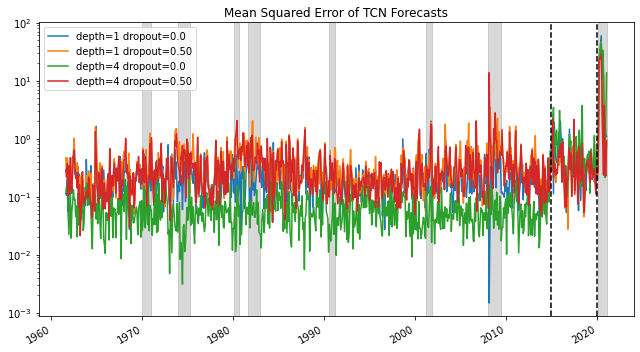

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), num=1, clear=True)
ax.set_yscale('log')
legend = []
for i, layer in enumerate([1, max(layers)]):
    for j, dropout in enumerate([0, int(100*max(dropouts))]):
        tcn_error[f"TCN{layer}_{dropout}"].plot(ax=ax, c=f'C{i*2+j}')
        legend.append(f"depth={layer} dropout=0.{dropout}")
for a,b in vspans:
    if a >= train_index[maxlags]:
        ax.axvspan(a, min(b, max(test2_index)), alpha=0.3, color='grey')
ax.set_title('Mean Squared Error of TCN Forecasts')
ax.axvline(max(train_index), color='black', linestyle='--')
ax.axvline(max(test1_index), color='black', linestyle='--')
ax.legend(legend, loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'tcnmse.jpg'))
plt.show()

## Display train and test error of TCN models by dropout and depth parameters
- Train errors decreasing by depth and increasing by dropout
- Test errors (weakly) increasing by depth and decreasing by dropout 
- Althought TCN could achieve lower training errors than VAR, test errors were larger than the more constrained/regularized method.

In [23]:
res.astype({'depth':int})\
   .rename(columns={s + ' Error': s for s in ['Train', 'Test1', 'Test2']})\
   .pivot(index=['dropout'], columns=['depth'])\
   .swaplevel(0, 1, 1).round(4).sort_index(axis=1)

depth         1                       2                       3          \
          Test1   Test2   Train   Test1   Test2   Train   Test1   Test2   
dropout                                                                   
0.0      0.4259  3.8017  0.2459  0.5429  2.9854  0.1209  0.5240  5.0325   
0.1      0.5085  4.5984  0.2716  0.4089  4.0991  0.1791  0.4146  3.1130   
0.2      0.4739  5.5211  0.2846  0.3803  5.9018  0.2158  0.3719  3.0211   
0.3      0.3239  2.2637  0.3288  0.3990  3.2749  0.2475  0.4130  2.9879   
0.4      0.3273  3.0602  0.3537  0.4011  3.0944  0.2926  0.3901  3.1538   
0.5      0.3480  3.6075  0.3879  0.3541  2.6604  0.3492  0.3500  2.4252   

depth                 4                  
          Train   Test1   Test2   Train  
dropout                                  
0.0      0.0803  0.5909  5.6749  0.0667  
0.1      0.1494  0.4044  3.2909  0.1186  
0.2      0.2023  0.3617  4.9397  0.1694  
0.3      0.2221  0.4185  2.8444  0.2170  
0.4      0.3016  0.9473  3.0438  0.2592  
0.5      0.3308  0.3572  2.5481  0.3445

## Plot Train and Test Error of TCN Models

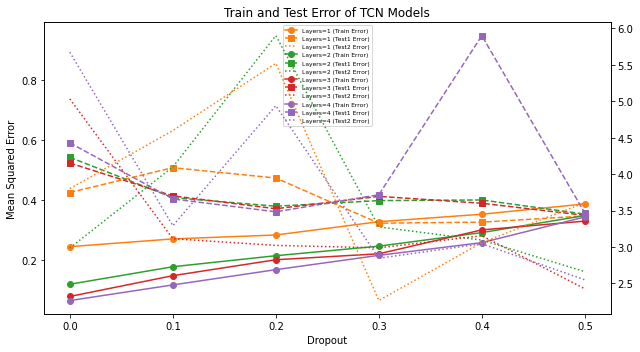

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), num=1, clear=True)
bx = ax.twinx()
for layer in np.unique(res.depth):
    select = res['depth'].eq(layer)
    Series(index=res['dropout'][select], data=res['Train Error'][select].values,
           name=f"Layers={layer:.0f} (Train Error)")\
           .plot(ax=ax, color=f"C{layer:.0f}", style='-', marker='o')
    Series(index=res['dropout'][select], data=res['Test1 Error'][select].values,
           name=f"Layers={layer:.0f} (Test1 Error)")\
           .plot(ax=ax, color=f"C{layer:.0f}", style='--', marker='s')
    ax.plot([],[], color=f"C{layer:.0f}", ls=':',
            label=f"Layers={layer:.0f} (Test2 Error)")
    Series(index=res['dropout'][select], data=res['Test2 Error'][select].values)\
           .plot(ax=bx, color=f"C{layer:.0f}", style=':')    
ax.set_title('Train and Test Error of TCN Models')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Dropout')
ax.legend(loc='upper center', fontsize=6)
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'tcn.jpg'))
plt.show()